[Info] Seed fixed to 42
Device: cuda
Loading 10 subjects from /content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET...

 >>> Starting Leave-One-Subject-Out (LOSO) Validation

[Fold 1/10] Testing on subject1 ...
[Info] Seed fixed to 42
  >>> Result: Pred 0.04 vs GT 20 (Diff: 19.96)


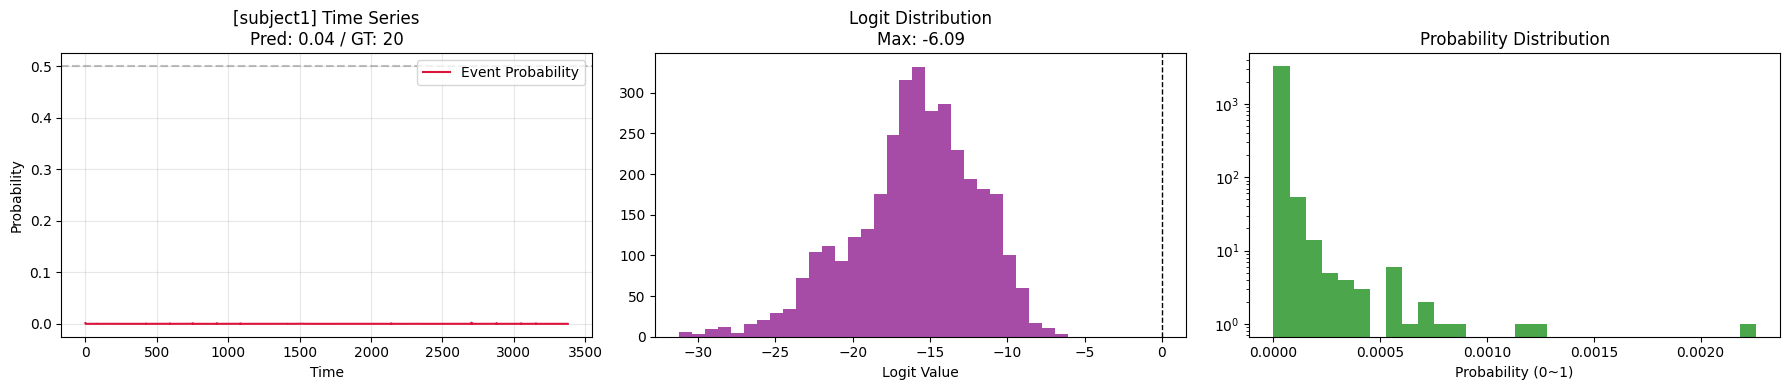


[Fold 2/10] Testing on subject2 ...
[Info] Seed fixed to 42
  >>> Result: Pred 0.11 vs GT 21 (Diff: 20.89)


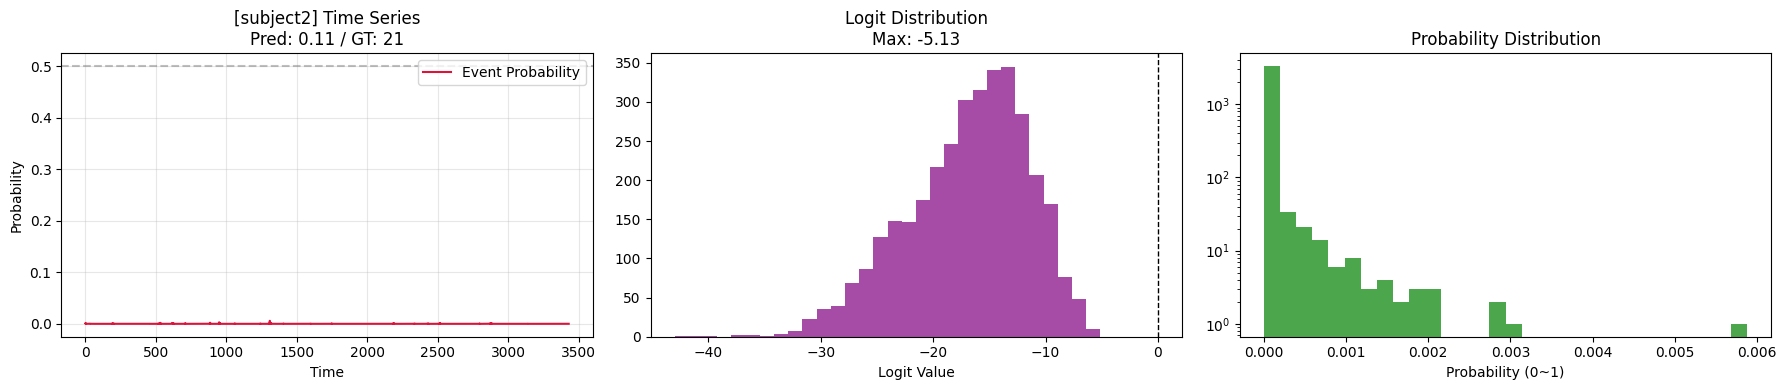


[Fold 3/10] Testing on subject3 ...
[Info] Seed fixed to 42
  >>> Result: Pred 0.17 vs GT 21 (Diff: 20.83)


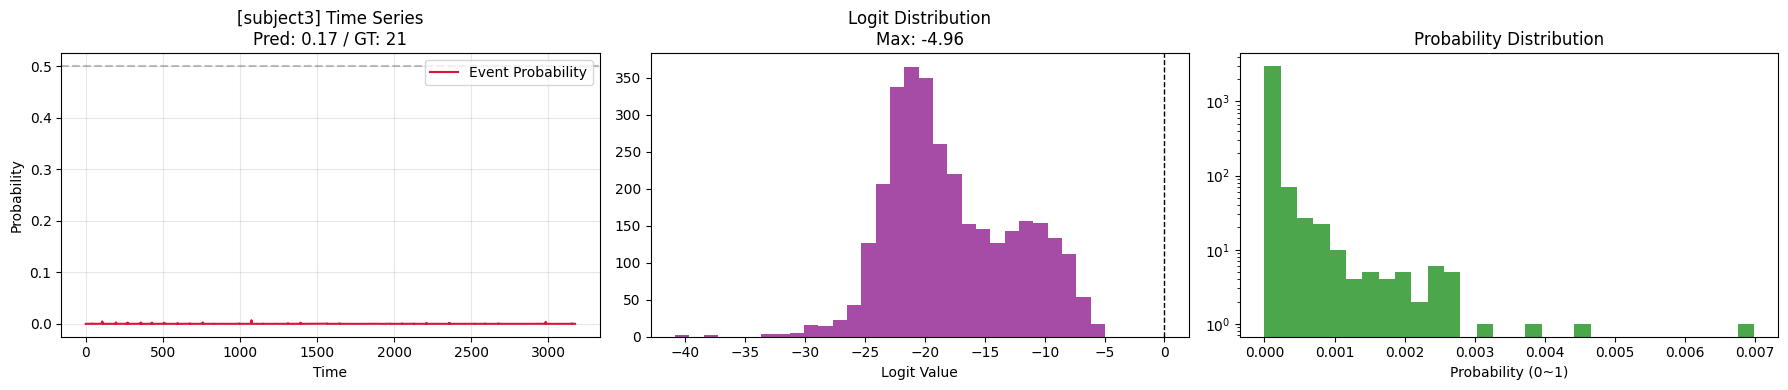


[Fold 4/10] Testing on subject4 ...
[Info] Seed fixed to 42
  >>> Result: Pred 0.09 vs GT 19 (Diff: 18.91)


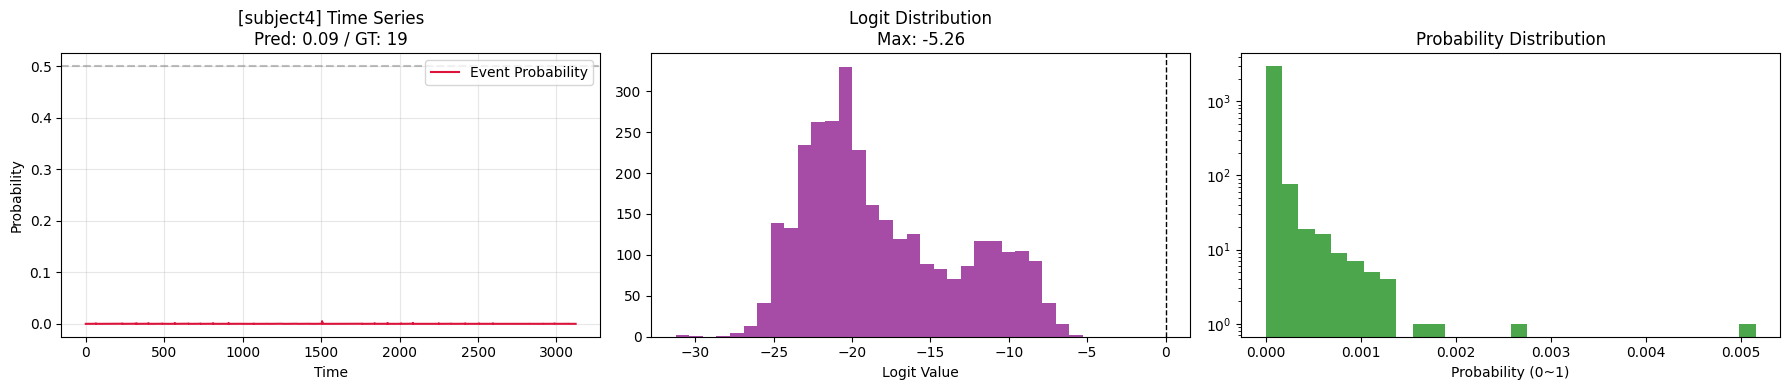


[Fold 5/10] Testing on subject5 ...
[Info] Seed fixed to 42
  >>> Result: Pred 0.01 vs GT 20 (Diff: 19.99)


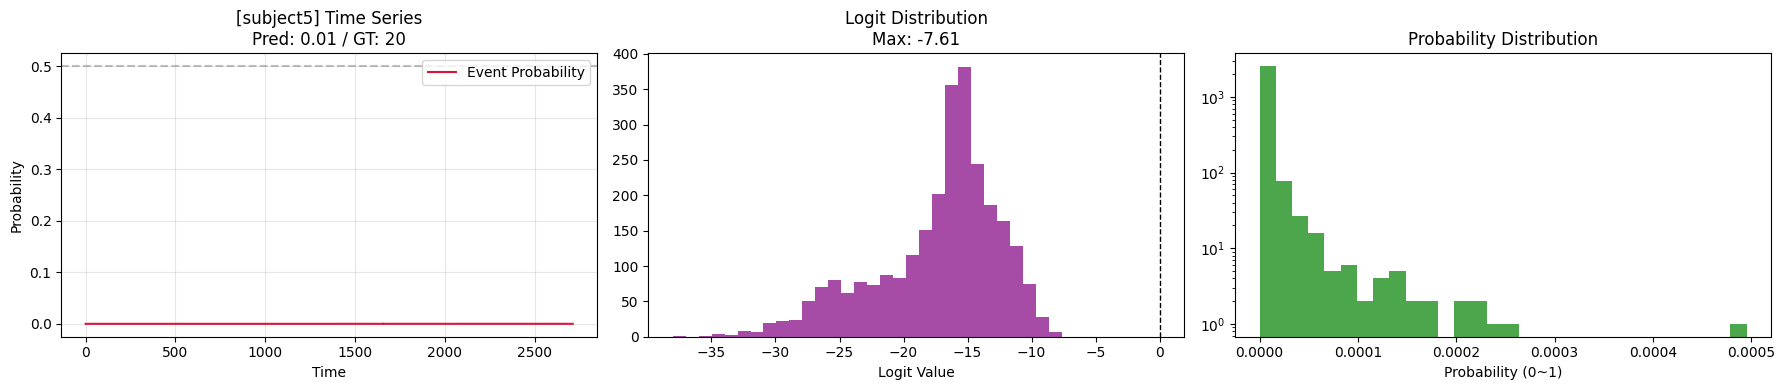


[Fold 6/10] Testing on subject6 ...
[Info] Seed fixed to 42
  >>> Result: Pred 0.04 vs GT 20 (Diff: 19.96)


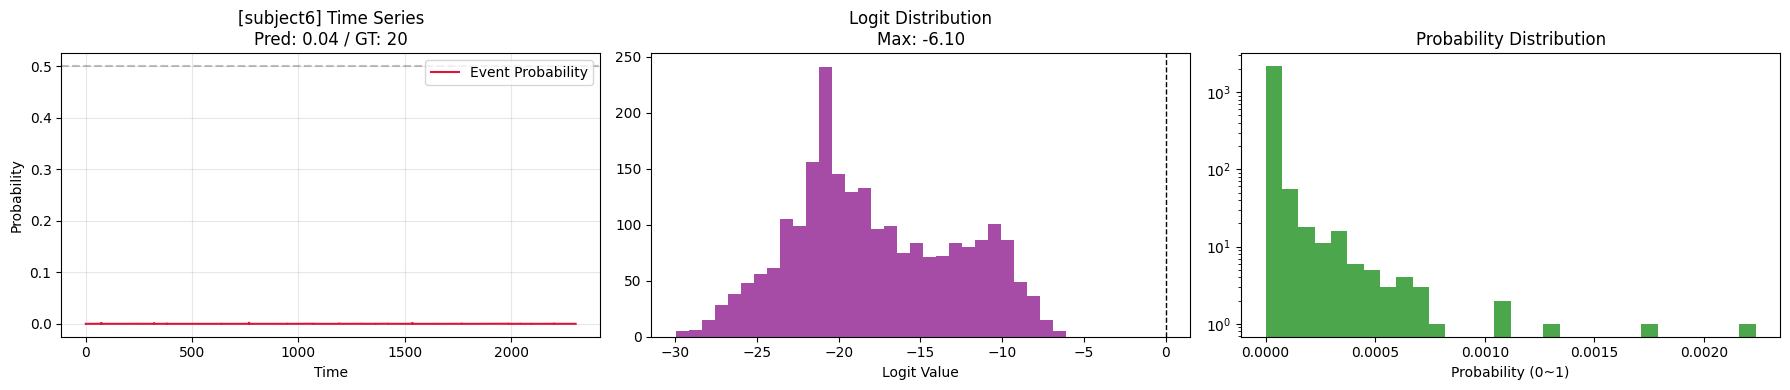


[Fold 7/10] Testing on subject7 ...
[Info] Seed fixed to 42
  >>> Result: Pred 0.09 vs GT 21 (Diff: 20.91)


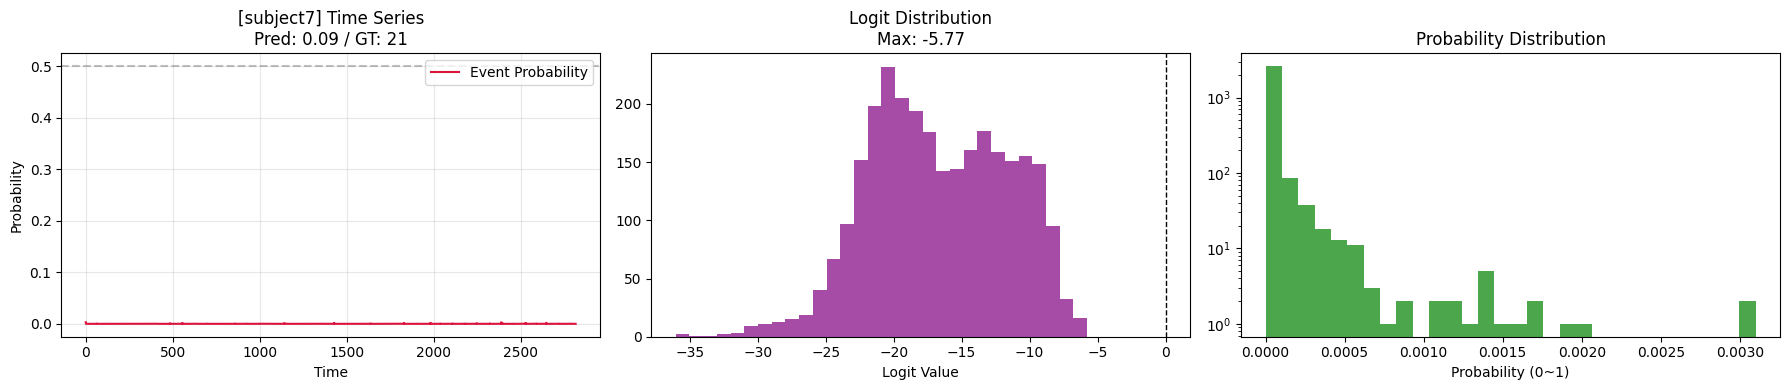


[Fold 8/10] Testing on subject8 ...
[Info] Seed fixed to 42
  >>> Result: Pred 0.03 vs GT 21 (Diff: 20.97)


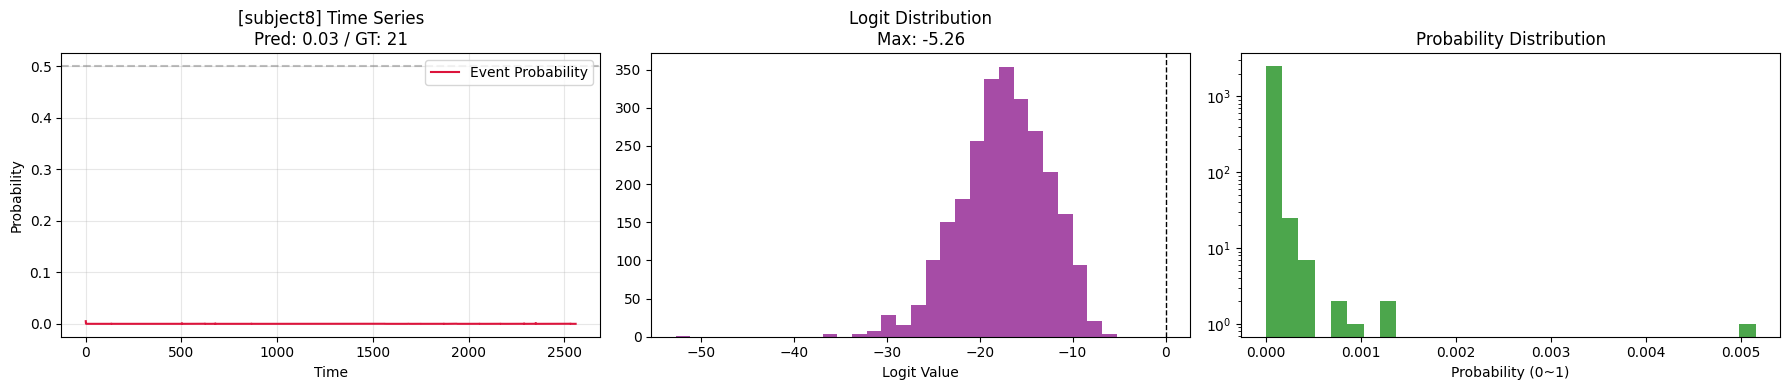


[Fold 9/10] Testing on subject9 ...
[Info] Seed fixed to 42
  >>> Result: Pred 0.05 vs GT 21 (Diff: 20.95)


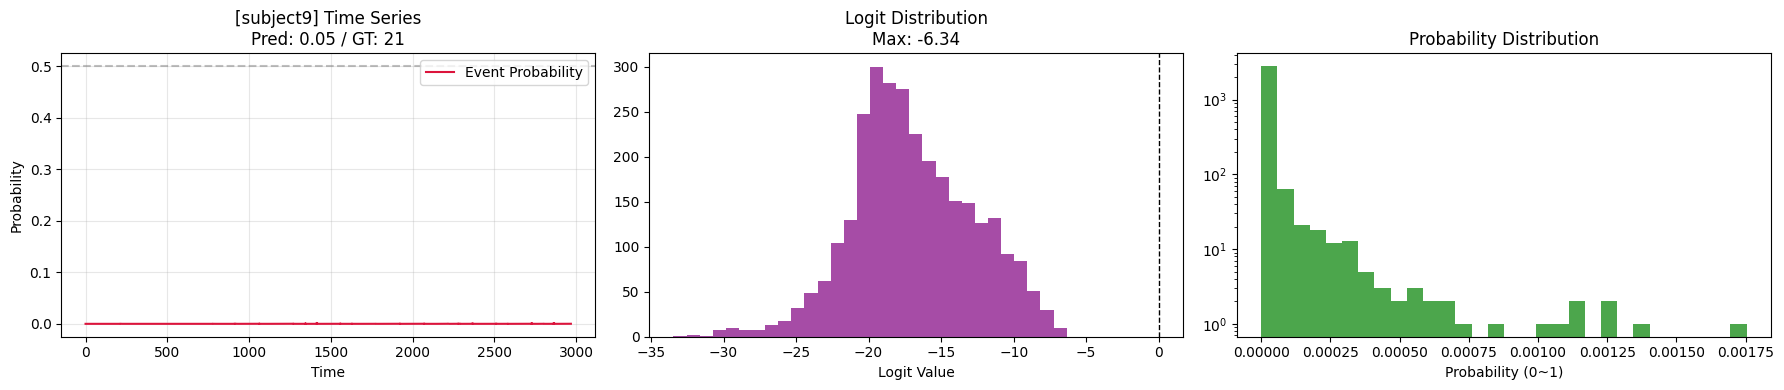


[Fold 10/10] Testing on subject10 ...
[Info] Seed fixed to 42
  >>> Result: Pred 0.16 vs GT 21 (Diff: 20.84)


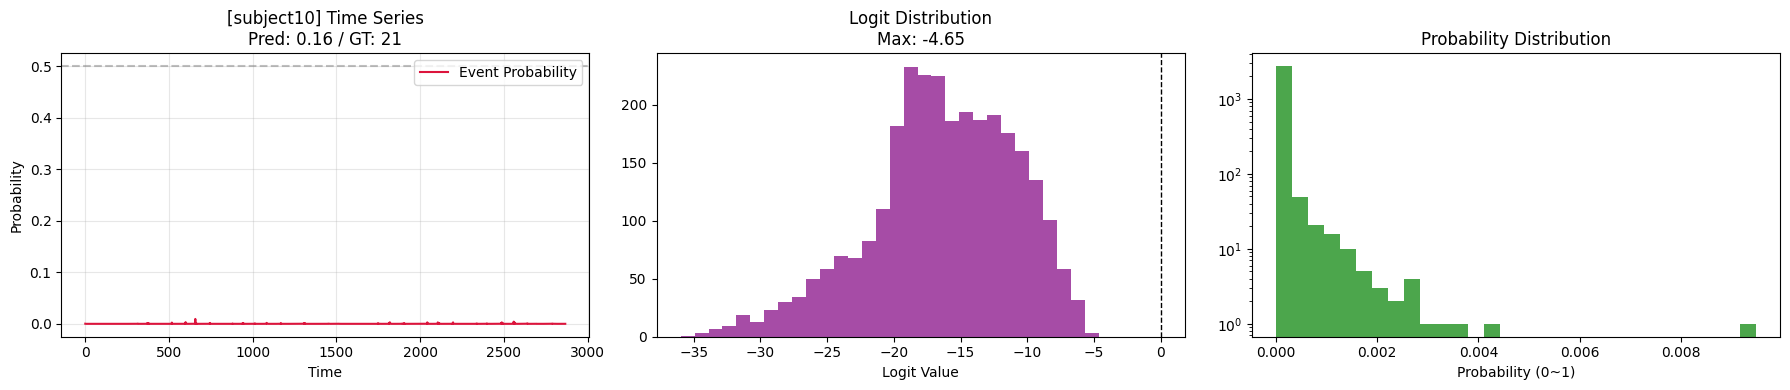


 >>> LOSO Finished. Average MAE: 20.42 ± 0.66
 >>> [Global Statistics] Total Samples: 29337
 >>> Logit Mean: -17.11 | Std: 4.98
 >>> Logit Max:  -4.65  | Min: -52.70


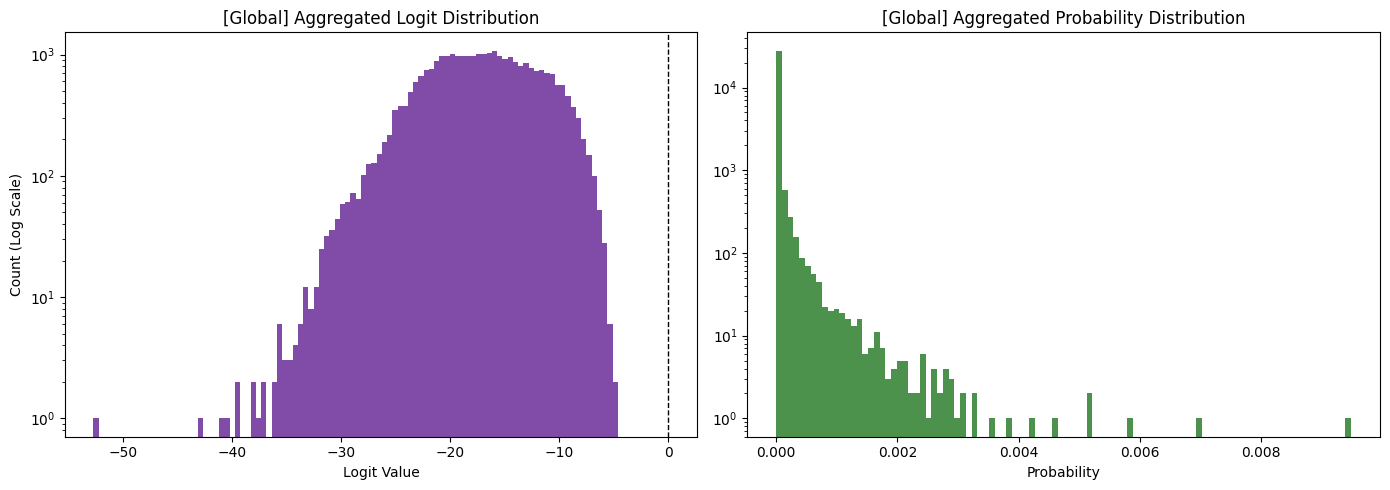

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ------------------------------------------------------------------------------
# 1. Strict Seeding
# ------------------------------------------------------------------------------
def set_strict_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"[Info] Seed fixed to {seed}")


# ------------------------------------------------------------------------------
# 2. Data Loading
# ------------------------------------------------------------------------------
def load_mhealth_dataset(data_dir, target_activities_map, column_names):
    full_dataset = {}
    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"[Warning] No mHealth logs found in {data_dir}")
        return {}

    print(f"Loading {len(file_list)} subjects from {data_dir}...")

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_part = file_name.split('.')[0]
        try:
            subj_id_num = int(''.join(filter(str.isdigit, subj_part)))
            subj_key = f"subject{subj_id_num}"
        except:
            subj_key = subj_part

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            df = df.iloc[:, :len(column_names)]
            df.columns = column_names

            subj_data = {}
            for label_code, activity_name in target_activities_map.items():
                activity_df = df[df['activity_id'] == label_code].copy()
                if not activity_df.empty:
                    subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

            full_dataset[subj_key] = subj_data
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            pass

    return full_dataset

def prepare_trial_list(label_config, full_data, target_map, feature_map):
    trial_list = []
    for subj, act_id, gt_count in label_config:
        act_name = target_map.get(act_id)
        feats = feature_map.get(act_id)

        if subj in full_data and act_name in full_data[subj]:
            # Get raw data (N, C)
            raw_df = full_data[subj][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)

            # Normalize (Z-score per trial)
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            trial_list.append({
                'data': norm_np,
                'count': float(gt_count),
                'meta': f"{subj}_{act_name}"
            })
        else:
            print(f"[Skip] Missing data for {subj} - {act_name}")

    return trial_list


# ------------------------------------------------------------------------------
# 3. Model Classes
# ------------------------------------------------------------------------------
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_ch, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, latent_dim, 1) # Project to latent
        )

    def forward(self, x):
        # x: (B, C, T)
        z = self.net(x) # (B, D, T)
        z = z.transpose(1, 2) # (B, T, D) for easier handling later
        return z

class ManifoldDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, kernel_size=5, padding=2),
            nn.GELU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2),
            nn.GELU(),
            nn.Conv1d(hidden_dim, out_ch, 1)
        )

    def forward(self, z):
        return self.net(z.transpose(1, 2)) # (B, C, T)
class EventnessHead(nn.Module):
    def __init__(self, latent_dim=3, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, z):
        # z: (B, T, D)
        return self.net(z).squeeze(-1) # (B, T)

class CountModel(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=3):
        super().__init__()
        self.encoder = ManifoldEncoder(input_ch, hidden_dim, latent_dim)
        self.decoder = ManifoldDecoder(latent_dim, hidden_dim, input_ch)
        self.event_head = EventnessHead(latent_dim, hidden_dim)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        nn.init.constant_(self.event_head.net[-1].bias, -2.0)

    def forward(self, x, mask=None):
        # x: (B, C, T)
        z = self.encoder(x) # (B, T, D)
        x_hat = self.decoder(z)

        logits = self.event_head(z) # (B, T)
        eventness = torch.sigmoid(logits)

        # Apply mask if provided (to ignore padding)
        if mask is not None:
            mask = mask.to(dtype=eventness.dtype, device=eventness.device)
            eventness = eventness * mask

        count_hat = eventness.sum(dim=1) # (B,)

        return count_hat, eventness, z, x_hat


# ------------------------------------------------------------------------------
# 4. Dataset & Collate
# ------------------------------------------------------------------------------
class TrialDataset(Dataset):
    """
    Wraps the loaded data to provide (sequence, count, meta)
    Compatible with Variable Length Collate
    """
    def __init__(self, trial_list):
        # trial_list: list of dicts {'data': np.array(T, C), 'count': float, 'meta': str}
        self.trials = trial_list

    def __len__(self):
        return len(self.trials)

    def __getitem__(self, idx):
        item = self.trials[idx]
        data = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1) # (C, T)
        count = torch.tensor(item['count'], dtype=torch.float32)
        return data, count, item['meta']

def collate_variable_length(batch):
    # batch: list of (data, count, meta)
    # data: (C, T)

    # 1. Find max length
    max_len = max([x[0].shape[1] for x in batch])
    C = batch[0][0].shape[0]

    padded_data = []
    masks = []
    counts = []
    metas = []

    for data, count, meta in batch:
        T = data.shape[1]

        # Pad data
        pad_size = max_len - T
        if pad_size > 0:
            pad = torch.zeros(C, pad_size)
            d_padded = torch.cat([data, pad], dim=1)
            mask = torch.cat([torch.ones(T), torch.zeros(pad_size)], dim=0)
        else:
            d_padded = data
            mask = torch.ones(T)

        padded_data.append(d_padded)
        masks.append(mask)
        counts.append(count)
        metas.append(meta)

    return {
        "data": torch.stack(padded_data), # (B, C, T_max)
        "mask": torch.stack(masks),       # (B, T_max)
        "count": torch.stack(counts),     # (B,)
        "meta": metas
    }


# ------------------------------------------------------------------------------
# 5. Training
# ------------------------------------------------------------------------------
def masked_recon_mse(x_hat, x, mask, eps=1e-6):
    """
    x_hat, x: (B, C, T)
    mask: (B, T)  (1=유효, 0=pad)
    """
    mask = mask.to(dtype=x.dtype, device=x.device)          # (B,T)
    mask_bc = mask.unsqueeze(1)                             # (B,1,T)
    se = (x_hat - x) ** 2                                   # (B,C,T)
    se = se * mask_bc
    denom = (mask.sum() * x.shape[1]) + eps                 # B*T_valid*C
    return se.sum() / denom

def train_one_epoch(model, loader, optimizer, config, device):
    model.train()
    total_loss = 0
    total_mae = 0
    total_pred = 0
    total_gt = 0

    total_loss_cnt = 0
    total_loss_recon = 0
    total_loss_sp = 0
    total_loss_tv = 0

    lambda_recon = config.get("lambda_recon", 1.0)
    lambda_count = config["lambda_count"]
    lambda_sparse = config["lambda_sparse"]
    lambda_tv = config["lambda_tv"]

    for batch in loader:
        x = batch["data"].to(device)   # (B, C, T)
        mask = batch["mask"].to(device) # (B, T)
        y_true = batch["count"].to(device) # (B,)

        optimizer.zero_grad()

        pred_count, eventness, z, x_hat = model(x, mask)

        # 1. Count Loss (MSE)
        loss_count = F.mse_loss(pred_count, y_true)

        # 2. Reconstruction Loss 계산
        loss_recon = masked_recon_mse(x_hat, x, mask)

        # 3. Sparsity / TV Loss
        loss_sparse = eventness.mean()
        loss_tv = torch.mean(torch.abs(eventness[:, 1:] - eventness[:, :-1]))

        loss = (lambda_count * loss_count +
                lambda_recon * loss_recon +
                lambda_sparse * loss_sparse +
                lambda_tv * loss_tv)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_loss_cnt += loss_count.item()
        total_loss_recon += loss_recon.item()
        total_loss_sp += loss_sparse.item()
        total_loss_tv += loss_tv.item()

        total_mae += torch.abs(pred_count - y_true).mean().item()
        total_pred += pred_count.mean().item()
        total_gt += y_true.mean().item()

    n = len(loader)
    return (total_loss/n, total_mae/n, total_pred/n, total_gt/n,
            total_loss_cnt/n, total_loss_recon/n, total_loss_sp/n, total_loss_tv/n)


# ------------------------------------------------------------------------------
# 6. Inference
# ------------------------------------------------------------------------------
def evaluation(model, trial_data, feature_names, device, gt_count=None, title="Result"):
    """
    Modified to work with single trial inference
    trial_data: (T, C) numpy array
    """
    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(trial_data, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device) # (1, C, T)
        count_hat, eventness, z, _ = model(x_tensor)
        count_val = count_hat.item()

    gt_str = f"{gt_count:.2f}" if gt_count is not None else "Unknown"

    print("-" * 50)
    print(f"   >>> Test Result | Pred: {count_val:.2f} vs GT: {gt_str}")
    print("-" * 50)

    return count_val


# ------------------------------------------------------------------------------
# 7. Visualization Helper Functions
# ------------------------------------------------------------------------------
def visualize_subject_result(subject_name, pred_count, gt_count, prob_np, logits_np):
    """
    각 Subject별 시계열(Time-series)과 히스토그램(Histogram)을 그립니다.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # 1. Time-series (Event Probability)
    axes[0].plot(prob_np, color='crimson', label='Event Probability')
    axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_title(f"[{subject_name}] Time Series\nPred: {pred_count:.2f} / GT: {gt_count}")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Probability")
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)

    # 2. Histogram (Logits)
    axes[1].hist(logits_np, bins=30, color='purple', alpha=0.7)
    axes[1].axvline(x=0, color='k', linestyle='--', linewidth=1)
    axes[1].set_title(f"Logit Distribution\nMax: {logits_np.max():.2f}")
    axes[1].set_xlabel("Logit Value")

    # 3. Histogram (Probability)
    axes[2].hist(prob_np, bins=30, color='green', alpha=0.7)
    axes[2].set_title("Probability Distribution")
    axes[2].set_xlabel("Probability (0~1)")
    axes[2].set_yscale('log') # 빈도 차이가 크므로 로그 스케일 추천

    plt.tight_layout()
    plt.show()

def visualize_global_distribution(all_logits, all_probs):
    """
    모든 Subject의 결과를 합쳐서 전체 분포를 시각화합니다.
    """
    # 리스트들을 하나의 큰 numpy array로 병합
    total_logits = np.concatenate(all_logits)
    total_probs = np.concatenate(all_probs)

    print("="*60)
    print(f" >>> [Global Statistics] Total Samples: {len(total_logits)}")
    print(f" >>> Logit Mean: {total_logits.mean():.2f} | Std: {total_logits.std():.2f}")
    print(f" >>> Logit Max:  {total_logits.max():.2f}  | Min: {total_logits.min():.2f}")
    print("="*60)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Global Logits
    axes[0].hist(total_logits, bins=100, color='indigo', alpha=0.7)
    axes[0].axvline(x=0, color='k', linestyle='--', linewidth=1)
    axes[0].set_title("[Global] Aggregated Logit Distribution")
    axes[0].set_xlabel("Logit Value")
    axes[0].set_ylabel("Count (Log Scale)")
    axes[0].set_yscale('log')

    # Global Probabilities
    axes[1].hist(total_probs, bins=100, color='darkgreen', alpha=0.7)
    axes[1].set_title("[Global] Aggregated Probability Distribution")
    axes[1].set_xlabel("Probability")
    axes[1].set_yscale('log')

    plt.tight_layout()
    plt.show()
# ------------------------------------------------------------------------------
# 8. Main with CONFIG
# ------------------------------------------------------------------------------
def main():

    CONFIG = {
        "seed": 42,
        "data_dir": "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET",

        "COLUMN_NAMES": [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'activity_id'
        ],
        "TARGET_ACTIVITIES_MAP": {
            6: 'Waist bends forward',
            7: 'Frontal elevation of arms',
            8: 'Knees bending',
            12: 'Jump front & back'
        },
        "ACT_FEATURE_MAP": {
            6: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_arm_x', 'acc_arm_y', 'acc_arm_z'],
            7: ['acc_arm_x', 'acc_arm_y', 'acc_arm_z', 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'],
            8: ['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z', 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z'],
            12: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']
        },

        # Training Params
        "epochs": 100,
        "lr": 5e-4,
        "batch_size": 64,  # Small batch size since sequences are long

        # Loss Weights
        "lambda_count": 1.0,
        "lambda_recon": 0.5,
        "lambda_sparse": 0.0,
        "lambda_tv": 0.005,

        # Model Arch
        "hidden_dim": 128,
        "latent_dim": 16,

        "ALL_LABELS": [
            # (Subject_ID, Activity_ID, True_Count)
            ("subject1", 8, 20),
            ("subject2", 8, 21),
            ("subject3", 8, 21),
            ("subject4", 8, 19),
            ("subject5", 8, 20),
            ("subject6", 8, 20),
            ("subject7", 8, 21),
            ("subject8", 8, 21),
            ("subject9", 8, 21),
            ("subject10", 8, 21),
        ],
    }

    # Setup
    set_strict_seed(CONFIG["seed"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # 1. Load Data
    full_data = load_mhealth_dataset(CONFIG["data_dir"], CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["COLUMN_NAMES"])
    if not full_data: return

    # Global aggregation containers
    global_logits = []
    global_probs = []
    loso_mae = []

    print("\n" + "="*50)
    print(" >>> Starting Leave-One-Subject-Out (LOSO) Validation")
    print("="*50)

    # ---------------------------------------------------------
    # LOSO Loop
    # ---------------------------------------------------------
    def logit(p, eps=1e-6):
        p = np.clip(p, eps, 1-eps)
        return float(np.log(p/(1-p)))

    num_subjects = len(CONFIG["ALL_LABELS"])

    for i in range(num_subjects):
        # 1. Split Data
        test_label_cfg = [CONFIG["ALL_LABELS"][i]]
        train_label_cfg = CONFIG["ALL_LABELS"][:i] + CONFIG["ALL_LABELS"][i+1:]

        target_subject = test_label_cfg[0][0]
        gt_count = test_label_cfg[0][2]

        print(f"\n[Fold {i+1}/{num_subjects}] Testing on {target_subject} ...")

        # 2. Reset Seed & Model (중요: Fold마다 초기화)
        set_strict_seed(CONFIG["seed"])

        train_data = prepare_trial_list(train_label_cfg, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])
        test_data = prepare_trial_list(test_label_cfg, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])


        if not train_data or not test_data:
            print(f"Skipping {target_subject} (Data missing)")
            continue

        # DataLoader
        train_loader = DataLoader(TrialDataset(train_data), batch_size=CONFIG["batch_size"],
                                  shuffle=True, collate_fn=collate_variable_length)

        # Model Init
        input_ch = train_data[0]['data'].shape[1]
        model = CountModel(input_ch=input_ch, hidden_dim=CONFIG["hidden_dim"], latent_dim=CONFIG["latent_dim"]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

        # 3. Training
        for epoch in range(CONFIG["epochs"]):
            stats = train_one_epoch(model, train_loader, optimizer, CONFIG, device)
            scheduler.step()
            # 로그 출력을 줄이려면 아래 주석 처리
            # if (epoch+1) % 50 == 0:
            #     print(f"  Ep {epoch+1} | Loss: {stats[0]:.4f} | MAE: {stats[1]:.2f}")

        # 4. Testing & Visualize (Individual)
        model.eval()
        with torch.no_grad():
            item = test_data[0] # Test 데이터는 1개임 (LOSO)
            x_tensor = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)

            # Forward
            pred_count, eventness, z, _ = model(x_tensor)

            # Convert to Numpy
            pred_val = pred_count.item()
            prob_np = eventness[0].cpu().numpy()

            # Logit 계산 (Visualization용)
            logits = model.event_head.net(z).squeeze(-1)
            logits_np = logits[0].cpu().numpy()

            # Result Print
            mae = abs(pred_val - gt_count)
            loso_mae.append(mae)
            print(f"  >>> Result: Pred {pred_val:.2f} vs GT {gt_count} (Diff: {mae:.2f})")

            # [시각화 1] 개별 Subject 결과 (시계열 + 히스토그램)
            visualize_subject_result(target_subject, pred_val, gt_count, prob_np, logits_np)

            # Global 분석을 위해 저장
            global_logits.append(logits_np)
            global_probs.append(prob_np)

    # ---------------------------------------------------------
    # Final Aggregation
    # ---------------------------------------------------------
    print("\n" + "="*50)
    print(f" >>> LOSO Finished. Average MAE: {np.mean(loso_mae):.2f} ± {np.std(loso_mae):.2f}")

    # [시각화 2] 전체 데이터 통합 분포 확인
    visualize_global_distribution(global_logits, global_probs)

if __name__ == "__main__":
    main()